In [3]:
from dataset import *

In [4]:
def pil_to_numpy(im):
    """
    Converts a PIL Image object to a NumPy array.
    Source : Fast import of Pillow images to NumPy / OpenCV arrays Written by Alex Karpinsky

    Args:
        im (PIL.Image.Image): The input PIL Image object.

    Returns:
        numpy.ndarray: The NumPy array representing the image.
    """
    im.load()

    # Unpack data
    e = Image._getencoder(im.mode, "raw", im.mode)
    e.setimage(im.im)

    # NumPy buffer for the result
    shape, typestr = Image._conv_type_shape(im)
    data = np.empty(shape, dtype=np.dtype(typestr))
    mem = data.data.cast("B", (data.data.nbytes,))

    bufsize, s, offset = 65536, 0, 0
    while not s:
        l, s, d = e.encode(bufsize)

        mem[offset : offset + len(d)] = d
        offset += len(d)
    if s < 0:
        raise RuntimeError("encoder error %d in tobytes" % s)
    return data

In [13]:
from PIL import Image

image_name = (
    "/home/ikergarcia/data/gtaai_datasets/test/car_city_day_clear/K0%3_3_3_5_5.jpeg"
)
# Read image into numpy array
image_splitter = SplitImages()
rm = RemoveMinimap(hide_map_prob=1)
image = Image.open(image_name)
image = pil_to_numpy(image)
# image = rm(image)
img = Image.fromarray(image, "RGB")
img.show()
image.shape

(270, 2400, 3)

In [11]:
image = image_splitter(image)

img = Image.fromarray(image[0], "RGB")
img.show()

In [16]:
tm = TubeMaskingGenerator((5, 270, 480), 0.9)

In [17]:
mask = tm()

In [18]:
mask.size()

torch.Size([648000])

In [13]:
from transformers import VideoMAEImageProcessor

In [14]:
image_processor = VideoMAEImageProcessor(
    do_resize=False,
    do_center_crop=False,
    do_rescale=True,
    do_normalize=True,
    image_mean=[0.33363932, 0.32581538, 0.31566033],
    image_std=[0.1914285, 0.18449214, 0.1853477],
)

In [25]:
model_inputs["pixel_values"].size()

torch.Size([1, 5, 3, 270, 480])

In [21]:
len(list(image))

5

In [1]:
from transformers import AutoImageProcessor, VideoMAEForPreTraining
import numpy as np
import torch

num_frames = 16
video = list(np.random.randint(0, 256, (num_frames, 3, 224, 224)))

image_processor = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base")
model = VideoMAEForPreTraining.from_pretrained(
    "MCG-NJU/videomae-base", torch_dtype=torch.bfloat16
).to("cuda")

pixel_values = image_processor(video, return_tensors="pt").pixel_values

num_patches_per_frame = (model.config.image_size // model.config.patch_size) ** 2
seq_length = (num_frames // model.config.tubelet_size) * num_patches_per_frame
bool_masked_pos = torch.randint(0, 2, (1, seq_length)).bool()

outputs = model(
    pixel_values.to(device=model.device, dtype=model.dtype),
    bool_masked_pos=bool_masked_pos,
)
loss = outputs.loss

loss.backward()

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/home/ikergarcia/miniconda3/envs/transformers/lib/python3.10/site-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1694072516410/work/torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(value)


logits: torch.bfloat16
labels: torch.float32
loss: torch.float32


RuntimeError: Found dtype Float but expected BFloat16

In [3]:
from modeling_videomae import VideoMAEForPreTraining
import torch

model = VideoMAEForPreTraining.from_pretrained(
    "models/VideoMAE-base", torch_dtype=torch.bfloat16
)

Some weights of VideoMAEForPreTraining were not initialized from the model checkpoint at models/VideoMAE-base and are newly initialized: ['decoder.decoder_layers.5.layernorm_before.weight', 'decoder.decoder_layers.0.attention.output.dense.bias', 'decoder.decoder_layers.5.attention.attention.v_bias', 'decoder.decoder_layers.0.attention.attention.key.weight', 'decoder.decoder_layers.5.layernorm_before.bias', 'decoder.decoder_layers.0.layernorm_before.weight', 'decoder.decoder_layers.0.output.dense.weight', 'decoder.decoder_layers.1.layernorm_after.bias', 'decoder.decoder_layers.3.attention.attention.v_bias', 'decoder.decoder_layers.2.output.dense.weight', 'decoder.decoder_layers.4.attention.output.dense.weight', 'decoder.decoder_layers.3.attention.attention.key.weight', 'decoder.decoder_layers.3.attention.output.dense.weight', 'decoder.decoder_layers.1.attention.output.dense.bias', 'decoder.decoder_layers.3.layernorm_after.weight', 'decoder.decoder_layers.4.attention.attention.key.weight

In [4]:
model.config

VideoMAEConfig {
  "_name_or_path": "models/VideoMAE-base",
  "architectures": [
    "VideoMAEModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "decoder_hidden_size": 384,
  "decoder_intermediate_size": 1536,
  "decoder_num_attention_heads": 6,
  "decoder_num_hidden_layers": 6,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": [
    270,
    480
  ],
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "videomae",
  "norm_pix_loss": true,
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_frames": 5,
  "num_hidden_layers": 12,
  "patch_size": 15,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.35.0",
  "tubelet_size": 1,
  "use_mean_pooling": true
}

In [1]:
from dataset import *

In [4]:
from transformers import VideoMAEImageProcessor as original_image_processor
from image_processing_videomae import VideoMAEImageProcessor as new_image_processor
import torch

In [2]:
IMAGE_MEAN: list[float] = [0.33363932, 0.32581538, 0.31566033]
IMAGE_STD: list[float] = [0.1914285, 0.18449214, 0.1853477]

image_processor_og = original_image_processor(
    do_resize=False,
    do_center_crop=False,
    do_rescale=True,
    do_normalize=True,
    image_mean=IMAGE_MEAN,
    image_std=IMAGE_STD,
)

image_processor_new = new_image_processor(
    do_resize=False,
    do_center_crop=False,
    do_rescale=True,
    do_normalize=True,
    image_mean=IMAGE_MEAN,
    image_std=IMAGE_STD,
)

In [3]:
import numpy as np

In [5]:
image_sequences = np.asarray(
                    [
                        np.random.rand(200, 200, 3)*255,
                    ]*128,
                    dtype=np.uint8,
                )

image_sequences = list(image_sequences)
print(len(image_sequences))
print(image_sequences[0].shape)
print(image_sequences[0][0][0][:10])




128
(200, 200, 3)
[119 129 132]


In [6]:
%%timeit
model_inputs_og = image_processor_og(
                        images=image_sequences,
                        input_data_format="channels_last",
                        return_tensors="pt",
                    )

/home/iker/miniconda3/envs/transformers/lib/python3.11/site-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(value)


1.11 s ± 123 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%%timeit
model_inputs_new = image_processor_new(
                        images=image_sequences,
                        input_data_format="channels_last",
                        return_tensors="pt",
                    )

154 ms ± 2.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
model_inputs_og = image_processor_og(
                        images=image_sequences,
                        input_data_format="channels_last",
                        return_tensors="pt",
                    )
model_inputs_og["pixel_values"].size()

torch.Size([1, 128, 3, 200, 200])

In [9]:
model_inputs_new = image_processor_new(
                        images=image_sequences,
                        input_data_format="channels_last",
                        return_tensors="pt",
                    )

model_inputs_new["pixel_values"].size()

torch.Size([1, 128, 3, 200, 200])

In [12]:
torch.all(model_inputs_new["pixel_values"]==model_inputs_og["pixel_values"])

tensor(True)

torch.Size([1, 5, 3, 270, 480])

In [1]:
from dataset import Tedd1104Dataset

In [2]:
dataset = Tedd1104Dataset(dataset_dir="/home/iker/Downloads/TEDD1104_Dev_Test/dev",hide_map_prob=0.0,patch_size=30, tubelet_size = 5,inference=False,tubelet_mask_ratio=0.2,image_mask_ratio=0.2)

In [3]:
model_input = dataset[0]["pixel_values"].unsqueeze(0)
model_input.size()

(270, 2400, 3)
torch.Size([270, 480, 3])
torch.Size([270, 480, 3])
torch.Size([270, 480, 3])
torch.Size([270, 480, 3])
torch.Size([270, 480, 3])
torch.Size([144])
torch.Size([144])


torch.Size([1, 5, 3, 270, 480])

In [7]:
image = dataset[0]["pixel_values"][0]

(270, 2400, 3)
torch.Size([270, 480, 3])
torch.Size([270, 480, 3])
torch.Size([270, 480, 3])
torch.Size([270, 480, 3])
torch.Size([270, 480, 3])
torch.Size([144])
torch.Size([144])


In [8]:
image.size()

torch.Size([3, 270, 480])

In [8]:
from modeling_videomae import VideoMAEEmbeddings, VideoMAEConfig

In [16]:
config = VideoMAEConfig(
    image_size=(270, 480),
    patch_size=15,
    num_channels=3,
    num_frames=5,
    tubelet_size=5,
    hidden_size=1200,
    num_hidden_layers=24,
    num_attention_heads=24,
    intermediate_size=5120,
    decoder_num_attention_heads=10,
    decoder_hidden_size=640,
    decoder_num_hidden_layers=10,
    decoder_intermediate_size=2560,
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
)

In [17]:
embeddings = VideoMAEEmbeddings(config)


In [19]:
embedding_output = embeddings(model_input, None)
embedding_output.size()

torch.Size([1, 576, 1200])

In [23]:
from transformers.models.mistral.modeling_mistral import MistralModel, MistralConfig

In [26]:
mistral_config = MistralConfig(
        vocab_size=32000,
        hidden_size=512,
        intermediate_size=512,
        num_hidden_layers=8,
        num_attention_heads=8,
        num_key_value_heads=8,
        hidden_act="silu",
        max_position_embeddings=4096 * 32,
        initializer_range=0.02,
        rms_norm_eps=1e-6,
        use_cache=True,
        pad_token_id=None,
        bos_token_id=1,
        eos_token_id=2,
        tie_word_embeddings=False,
        rope_theta=10000.0,
        sliding_window=4096,
        attention_dropout=0.0,)
encoder = MistralModel(mistral_config)

In [28]:
encoder_outputs = encoder(
            embedding_output,
            attention_mask=None,
            output_attentions=False,
            output_hidden_states=False,
            return_dict=False,
        )


ValueError: too many values to unpack (expected 2)

In [29]:
mask.size()

torch.Size([2880])

In [6]:
from configuration_videomae import VideoMAEConfig
from modeling_videomae import VideoMAEModel, VideoMAEForVideoClassification
from utils import get_trainable_parameters
import os
import argparse


In [7]:
config = VideoMAEConfig(
            image_size=(270, 480),
            patch_size=15,
            num_channels=3,
            num_frames=5,
            tubelet_size=1,
            hidden_size=384,
            num_hidden_layers=4,
            num_attention_heads=6,
            intermediate_size=1536,
            decoder_num_attention_heads=3,
            decoder_hidden_size=192,
            decoder_num_hidden_layers=3,
            decoder_intermediate_size=1536,
            hidden_dropout_prob=0.1,
            attention_probs_dropout_prob=0.1,
        )

In [8]:
m =  VideoMAEForVideoClassification(config)

In [9]:
m

VideoMAEForVideoClassification(
  (videomae): VideoMAEModel(
    (embeddings): VideoMAEEmbeddings(
      (patch_embeddings): VideoMAEPatchEmbeddings(
        (projection): Conv3d(3, 384, kernel_size=(1, 15, 15), stride=(1, 15, 15))
      )
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-3): 4 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=384, out_features=1

In [5]:
from dataset import TubeMaskingGenerator, ImageMaskingGenerator

tubemaskgen = TubeMaskingGenerator(0.2,15,1)
imagemaskgen = ImageMaskingGenerator(0.2,15,1)

In [6]:
tubemask = tubemaskgen()
imagemask = imagemaskgen()


In [7]:
tubemask.size()


torch.Size([2880])

In [8]:
imagemask.size()

torch.Size([2880])

In [25]:
tubemask

tensor([ True, False,  True,  ...,  True, False, False])

In [26]:
imagemask

tensor([False, False, False,  ..., False, False, False])

In [27]:
(tubemask | imagemask)[:10]

tensor([ True, False,  True, False, False, False, False, False, False, False])

In [9]:
from dataset import *

In [11]:
image_splitter = SplitImages()
image_color_jitter = SequenceColorJitter()

In [25]:
image: np.array = pil_to_numpy(Image.open("/home/iker/Downloads/TEDD1104_Dev_Test/dev/K72%5_5_1_3_7.jpeg"))


In [26]:
images: List[torch.tensor] = image_splitter(image)

(270, 2400, 3)
torch.Size([270, 480, 3])
torch.Size([270, 480, 3])
torch.Size([270, 480, 3])
torch.Size([270, 480, 3])
torch.Size([270, 480, 3])


In [27]:
images = image_color_jitter(images)

In [28]:
images[0].size()

torch.Size([270, 480, 3])

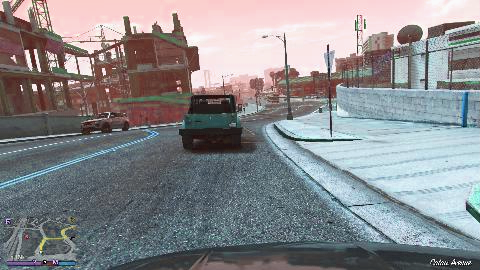

In [29]:
# Show image
img = Image.fromarray(images[0].numpy(), "RGB")
img

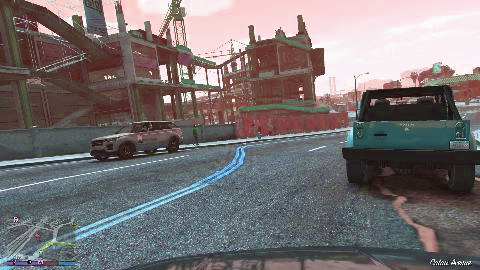

In [30]:
img = Image.fromarray(images[4].numpy(), "RGB")
img